# Projet Techniques de Simulation

In [8]:
#imports 
import random as rd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import threading
import bisect
from PIL import Image
from IPython.display import display
print("Dépendances importées")

Dépendances importées


## 1° Construction de nos objets

[Table de Walker] : 
|A-1 : 0.10|A-2 : 0.16|A-3 : 0.13|A-4 : 0.10|A-5 : 0.16|A-6 : 0.10|
|A-2 : 0.06|          |A-5 : 0.03|A-2 : 0.06|          |A-3 : 0.06|


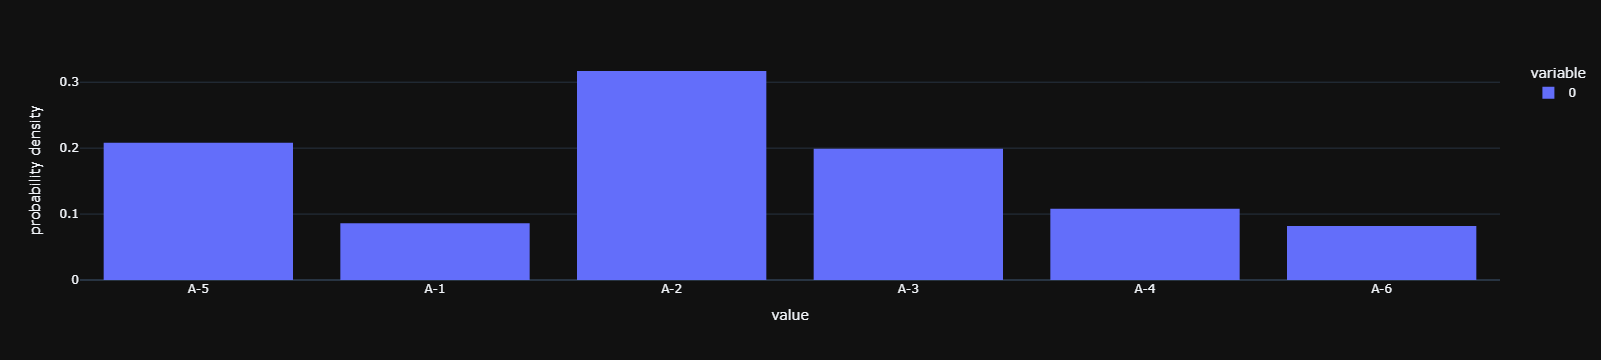

In [2]:
class walkerTable():
    def __init__(self, distribution : (float), distribution_values : tuple):
        """construction de la table de walker.
        Distribution est un tuple qui contient notre distribution de probablité.
        Distribution_values est un tuple qui contient les valeurs associées a notre distribution de probablité."""

        assert len(distribution) == len(distribution_values), "Tuples de tailles differentes. \n" + str(len(distribution)) + "x" + str(len(distribution_values)) #verification d'usage. Il doit y avoir autant de valeurs que le cardinal de notre distribution.
        self.distribution_values = distribution_values
        self.distribution = distribution
        self.n = len(self.distribution)
        #dictionnaire de distributions. 
        self.dt_01 = dict(zip([i for i in range(self.n)],
                             [
                                 [self.distribution_values[k],
                              self.distribution[k]] for k in range(self.n)]
                             )
                         )
        #dictionnaire des distributions compilées.
        self.dt_02 = dict(zip([i for i in range(self.n)],
                             [
                                 [] for k in range(self.n)]
                             )
                         )
        H = [] #Cela doit etre une liste temporaire. Liste des distribution superieures a la moyenne.
        L = [] #Cela doit etre une liste temporaire. Liste des distribution inferieures a la moyenne.
        for k in range(self.n):
            var = self.distribution[k]*self.n
            if var < 1:
                L.append(k)
            elif var > 1:
                H.append(k)
        #Listes H et L remplies.
        while (H != []) and (L != []):
            up = H[0] #indice de la premiere distribution superieure a la moyenne.
            low = L[0] #indice de la premiere distribution superieure a la moyenne.
            self.dt_01[up][1] = self.dt_01[up][1] - (1/self.n - self.dt_01[low][1])
            self.dt_02[low].append(self.dt_01[up][0]) #on rajoute la valeur de la distribution compilée
            self.dt_02[low].append((1/self.n - self.dt_01[low][1])) #on rajoute sa probabilité
            L.pop(0) #La sortie de low de la liste L est certaine, mais celle de up ne l'est pas.
            if (self.dt_01[up][1]*self.n < 1):
                L.append(up)
                H.pop(0)
            elif (self.dt_01[up][1]*self.n == 1):
                H.pop(0)
            pass
    def __repr__(self):
        return "[Table de Walker] : \n" + "|" + "|".join([elt[0] + " : " + str(elt[1] + 0.0000000001)[:4] for elt in self.dt_01.values()]) + "|" + "\n" + "|" + "|".join([self.dt_02[key][0] + " : " + str(self.dt_02[key][1] + 0.0000000001)[:4] if self.dt_02[key] != [] else " "*(7 + len(self.dt_01[key][0])) for key in self.dt_02.keys()]) + "|" 
    def __str__(self):
        return "[Table de Walker] : \n" + "|" + "|".join([elt[0] + " : " + str(elt[1] + 0.0000000001)[:4] for elt in self.dt_01.values()]) + "|" + "\n" + "|" + "|".join([self.dt_02[key][0] + " : " + str(self.dt_02[key][1] + 0.0000000001)[:4] if self.dt_02[key] != [] else " "*(7 + len(self.dt_01[key][0])) for key in self.dt_02.keys()]) + "|"
    def run(self):
        """Simulation de la distribution de probabilité a support fini"""
        U = rd.random() #Loi uniforme sur [0,1]
        var = int(U*self.n) #Partie entiere d'une loi uniforme sur [|0,n-1|]
        #Loi de bernoulli
        if (self.dt_02[var] == []) or ((U*self.n - var) <= self.dt_01[var][1]*self.n):
            return self.dt_01[var][0]
        else:
            return self.dt_02[var][0]
    def empiricLikelihood(self, n=1000):
        """Affiche l'histogramme de notre distribution pour n simmulation"""
        assert n != 0, "distribution non spécifiée"
        fig = px.histogram([self.run() for k in range(n)], histnorm='probability density', template="plotly_dark")
        fig.show()
test = walkerTable((0.1,0.3,0.2,0.1,0.2,0.1),("A-1","A-2","A-3","A-4","A-5","A-6"))
print(test)
test.empiricLikelihood()

current state : A
|| 0.86 | 0.04 | 0.04 | 0.04 ||
|| 0.78 | 0.19 | 0.00 | 0.01 ||
|| 0.71 | 0.16 | 0.02 | 0.09 ||
|| 0.13 | 0.24 | 0.20 | 0.42 ||



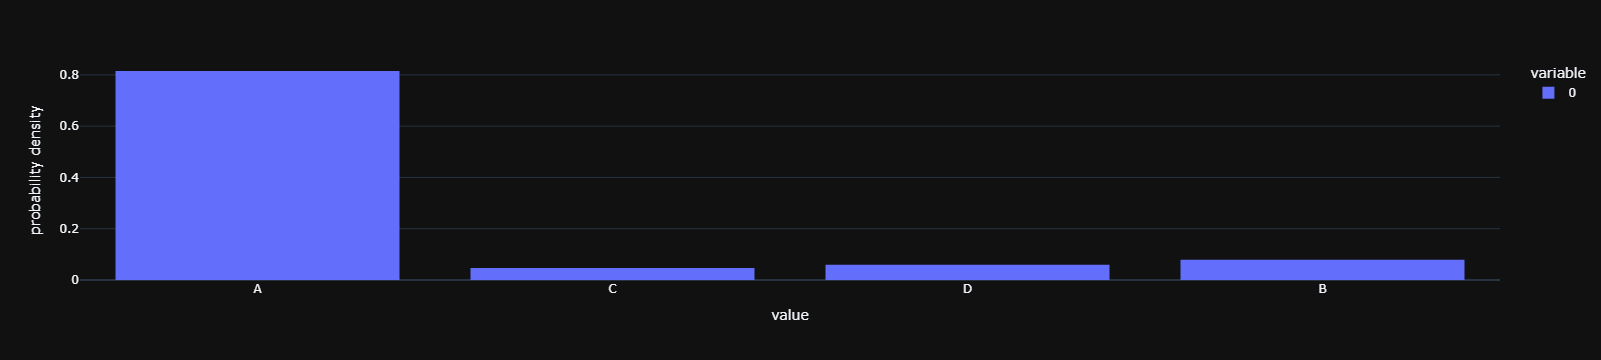

In [3]:
def get_a_random_distribution(n : int):
    """genere une distribution de probabilité a support fini."""
    substrat=[]
    for k in range(n):
        if (k==n-1) and (substrat!=[]):
            substrat.append(1-sum(substrat))
        else:
            substrat.append(np.random.uniform(0,1-sum(substrat)))
    return substrat
    
class Constructuer_Chaine_Markovienne():
    def __init__(self, states : tuple, mu_zero_dis : (float), transitions : [(float)]):
        self.states = states
        self.mu_zero_dis = mu_zero_dis
        self.transitions = transitions
        self.transitions_walker_table = [walkerTable(distribution=line,distribution_values=states) for line in transitions]
        self.mu_zero = walkerTable(distribution=mu_zero_dis,distribution_values=states)
        self.indexa = dict(zip(states,range(len(states))))
    def __repr__(self):
        return str(self.states) + "\n" + self.mu_zero.__repr__() + "\n" + "".join([line.__repr__() + "\n" for line in self.transitions_walker_table])
    def __str__(self):
        return str(self.states) + "\n" + self.mu_zero.__str__() + "\n" + "".join([line.__str__() + "\n" for line in self.transitions_walker_table])
class Chaine_Markovienne():
    def __init__(self, constructor):
        """Chaine_Markovienne modélise une chaine de markov a support fini.
        States est un tuple contenant tous les etats de la chaine.
        mu_zero (un tuple) est la distribution a support fini de la loi de X0.
        transitions la matrice de transition.
        o(n)
        """
        assert len(constructor.states) !=0, "Chaine sans états"
        self.states = constructor.states
        self.mu_zero = constructor.mu_zero
        self.state = self.mu_zero.run()
        self.round = 0
        self.transitions = constructor.transitions
        self.transitions_walker_table = constructor.transitions_walker_table
        self.indexa = constructor.indexa
        pass
    def run(self, rounds : int):
        """Simule la trajectoire d'une chaine de markov avec un temps d'arret discret T = rounds"""
        for i in range(rounds):
            self.state = self.transitions_walker_table[self.indexa[self.state]].run()
            self.round = self.round + 1
        return self.state
    def __repr__(self):
        txt = "\n"
        for k in self.transitions:
            txt = txt + "||"
            for i in range(len(k)):
                txt = txt + " " + str(k[i] + 0.0000000001)[:4] + " |"
            txt = txt + "|\n"
        return "current state : " + str(self.state) + txt
    def __str__(self):
        txt = "\n"
        for k in self.transitions:
            txt = txt + "||"
            for i in range(len(k)):
                txt = txt + " " + str(k[i] + 0.0000000001)[:4] + " |"
            txt = txt + "|\n"
        return "current state : " + str(self.state) + txt
    def reinit(self):
        self.state = self.mu_zero.run()
        self.round = 0
        pass
    def empiricLikelihood(self, n=1000):
        """Affiche l'histogramme de notre distribution pour n simmulation"""
        assert n != 0, "distribution non spécifiée"
        fig = px.histogram([self.run(rounds=1000) for k in range(n)], histnorm='probability density', template="plotly_dark")
        fig.show()
constructor_test = Constructuer_Chaine_Markovienne(states=("A","B","C","D"),
                         mu_zero_dis=get_a_random_distribution(4),
                         transitions=[get_a_random_distribution(4) for i in range(4)])
test1 = Chaine_Markovienne(constructor=constructor_test)
print(test1)
test1.empiricLikelihood()

In [4]:
class Settings():
    def __init__(self, x_0=np.random.uniform(0,1), b=np.random.uniform(0.1,1), sigma=np.random.uniform(0.1,1), delta=np.random.uniform(0.1,1), a=np.random.uniform(0.1,1), alpha=np.random.uniform(1,10), u=np.random.uniform(100,200), c=np.random.uniform(0.1,1), N=rd.randint(1,10000), monte_carlo_limit=10000, lambda_01=np.random.uniform(0.1,1), lambda_02=np.random.uniform(0.1,1), lambda_03=np.random.uniform(0.1,1)):
        """
        Contient toutes les variables initiales de nos modeles
        """
        self.colors = {"bg" : 0}
        self.parameters = {"x 0" : x_0,
                          "b" : b,
                          "sigma" : sigma,
                          "delta" : delta,
                          "a" : a,
                          "alpha" : alpha,
                          "u" : u,
                          "c" : c,
                          "N" : N,
                          "limite machine de monte carlo limit" : monte_carlo_limit,
                          "lambda 01" : lambda_01,
                          "lambda 02" : lambda_02,
                          "lambda 03" : lambda_03}
    def __repr__(self):
        return "Parametres du modèle : " + "\n" + "\n".join([" - " + str(elt) + " : " + str(self.parameters[elt]) for elt in self.parameters.keys()])
    def __str__(self):
        return "Parametres du modèle : " + "\n" + "\n".join([" - " + str(elt) + " : " + str(self.parameters[elt]) for elt in self.parameters.keys()])
test = Settings()
test

Parametres du modèle : 
 - x 0 : 0.3458905571261437
 - b : 0.7380067756635832
 - sigma : 0.8139640817979881
 - delta : 0.4153651085786332
 - a : 0.5981637287787575
 - alpha : 3.0794933028300795
 - u : 108.92159725013684
 - c : 0.6180419903389195
 - N : 2634
 - limite machine de monte carlo limit : 10000
 - lambda 01 : 0.455311425284887
 - lambda 02 : 0.366794523561667
 - lambda 03 : 0.49387466955014014

---
## Parametres du modele

In [183]:
ProjectSettings = Settings(lambda_01=1.471e-04, lambda_02=7.786e-03, lambda_03=3.510e-2, c=3, u=10000, b=4000, alpha=0.4, a=10, x_0=3000, N=1000)

### Couts des sinistres
---

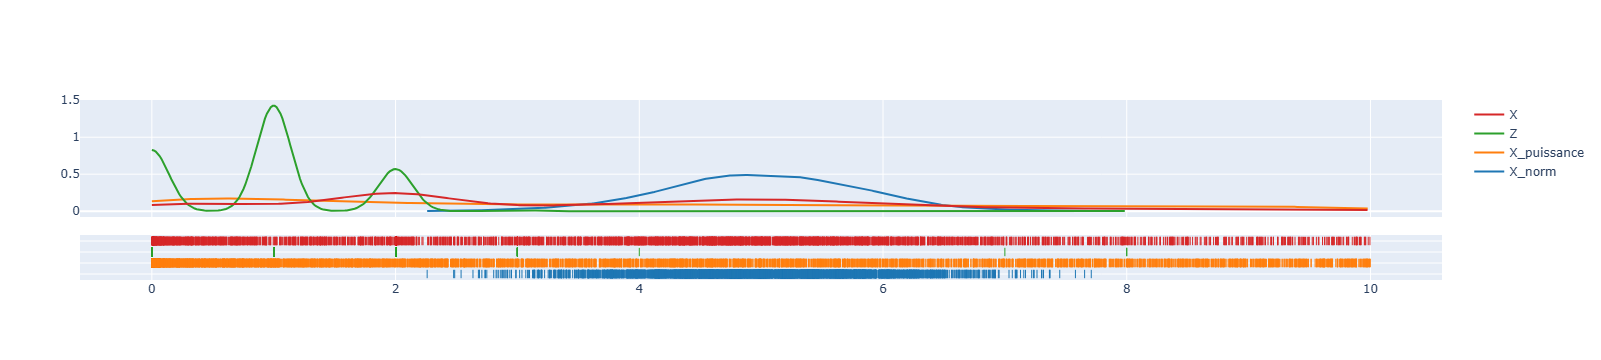

In [158]:
class Sinistre():
    def __init__(self, settings=ProjectSettings, p=get_a_random_distribution(n=10)):
        self.settings = settings
        self.p = p
    def f_norm(self, x : float):
        """f_norm est la loi selon  laquelle on doit simuler pour obtenir Pnorm"""
        ind = (x >= 0) & (x <= self.settings.parameters["b"])
        return ind*(np.exp(-((x - self.settings.parameters["x 0"])**2) / (2 * self.settings.parameters["sigma"]**2)) * (1 + np.cos(2*np.pi*(x - self.settings.parameters["x 0"])/self.settings.parameters["delta"])**2))
    def g(self, x : float):
        return (1 / (np.sqrt(2*np.pi)*self.settings.parameters["sigma"])) * np.exp(-((x - self.settings.parameters["x 0"])**2) / (2 * self.settings.parameters["sigma"]**2))
    def f_norm_run(self):
        while True:
            X = np.random.normal(self.settings.parameters["x 0"], self.settings.parameters["sigma"])   
            Y = np.random.uniform(0, 2*np.sqrt(2*np.pi)*self.settings.parameters["sigma"])
            if Y*self.g(x=X) <= self.f_norm(x=X):
                return X #condition d'acceptation, boucle brisée
    def loi_de_puissance_run(self):
        return self.settings.parameters["a"]*(1 - rd.random())**(1/(1-self.settings.parameters["alpha"]))
    def loi_z_run(self):
        M = np.max(self.p)
        k = len(self.p)
        while True:
            I = np.random.randint(0, k) 
            U = np.random.uniform(0, M)
            if U <= self.p[I]:
                return I #condition d'acceptation, boucle brisée
    def loi_X_run(self):
        z = self.loi_z_run()
        return (z == 0)*self.f_norm_run() + (z == 1)*self.loi_de_puissance_run() + (z > 1)*z
    def empiricLikelihood(self, n=4000):
        hist_data = [[self.f_norm_run() for i in range(n)],[self.loi_de_puissance_run() for i in range(n)],[self.loi_z_run() for i in range(n)],[self.loi_X_run() for i in range(n)]]
        group_labels = ["X_norm", "X_puissance","Z","X"]
        fig = ff.create_distplot(hist_data, group_labels, show_hist=False)
        fig.show()
test = Sinistre(settings=Settings(lambda_01=1.471e-04, lambda_02=7.786e-03, lambda_03=3.510e-2, c=0.1, u=10000, b=10, alpha=0.4, a=10, x_0=5))
test.empiricLikelihood()

---
## 2° Modélisation

---

$(H_k)_{k \in N}$, une *chaine de markov*, possédant les attributs suivants : 

 - *ensemble d'états* $E = \{ 1, 2, 3 \}$

 - *loi initiale* $\mu_0$, une permutaion quelconque de $(1,0,0)$

 - de *matrice(stochastique) de transition * $Q \in M_3(R)$ :

$$
\begin{bmatrix}
p_{1,1} & p_{1,2} & p_{1,3}\\
p_{2,1} & p_{2,2} & p_{2,3}\\
p_{3,1} & p_{3,2} & p_{3,3}
\end{bmatrix}
$$

---


$$
	\lambda : 
	\begin{cases}
		[|1,3|] \to R_{+}^{*}\\
		t \longmapsto \lambda_t
	\end{cases}
	.
$$

$\lambda$, caractérisant les valeurs $(\lambda_1, \lambda_2, \lambda_3)$ associées aux valeurs respectives $(1,2,3)$ de la *chaine de markov* $(H_k)_{k \in N}$

---

Posons : $$ \forall t \in \mathbb{R}, \Delta^{*}(t) = N 1_{[0,365]}(t) \epsilon_{H_{\lfloor t \rfloor}}$$

$$\forall t \in [0,365]$$ $$ \mu^{*}(t) = \int_{0}^{t} \Delta^{*}(x)dx  $$

Soit $(T_t)_{t \in R_{+}^{*}}$, un processus de poisson in-homogène mélange ***d'intensité*** : $\Delta^{*}$ 

In [177]:
class SubModel_A(Chaine_Markovienne,threading.Thread):
    def __init__(self, settings, constructor, sinister, theta, global_array, global_number):
        super().__init__(constructor=constructor)
        threading.Thread.__init__(self)
        self.settings = settings
        random_mu_zero = [0]*3
        random_mu_zero[rd.randint(0,2)] = 1 #Car mu_zero est sensée etre déterministe
        self.sinister = sinister
        self.mu_zero = walkerTable(distribution=random_mu_zero,distribution_values=self.states)
        self.T, self.Rt, self.X, self.trajectory, self.theta = [0], [self.settings.parameters["N"]*self.settings.parameters["u"]], [0], {0 : 0}, theta #contenant respectivement les temps d'occurence de nos sinistres et les montants
        self.global_array = global_array
        self.global_number = global_number
        pass
    def __repr__(self):
        return self.settings.__repr__() + "\n" + super().__repr__() #+ tgraph_draw(states=self.states, state=self.state)
    def __str__(self):
        return self.settings.__str__() + "\n" + super().__str__() #+ tgraph_draw(states=self.states, state=self.state)
    def run_ruine(self, rounds=365, draw=True):
        N_sim = np.random.poisson(lam=self.theta*rounds)
        #Nous essayer d'optimiser le code de facon a que l'on ait besoin de simmuler toute la trajectoire de la chaine de markov, si et seulement si l'information qu'elle apport nous ait nécéssaire.
        for k in range(N_sim):
            va_transitoire = np.random.uniform(0,rounds)
            va_transitoire_aux = int(va_transitoire)
            if (va_transitoire_aux in self.trajectory): #recherche en temps constant
                if (np.random.uniform(0,self.theta) <= self.settings.parameters["N"]*self.trajectory[va_transitoire_aux]):
                    bisect.insort(self.T,va_transitoire) #o(lnn)
            else:
                for i in range(va_transitoire_aux - self.round + 2): #Nombre de tours qu'il nous reste pour que va_transitioire_aux soit dans le dictionnaire
                    self.state, self.round, self.trajectory[self.round] = self.transitions_walker_table[self.indexa[self.state]].run(), self.round + 1, self.state
                if (np.random.uniform(0,self.theta) <= self.settings.parameters["N"]*self.trajectory[va_transitoire_aux]):
                    bisect.insort(self.T,va_transitoire) #o(lnn)
        draw_t = [0]
        rt_draw = [self.settings.parameters["N"]*self.settings.parameters["u"]]
        for i in range(1,len(self.T)):
            aux = rt_draw[-1]
            rt_draw.append(aux + self.settings.parameters["N"]*self.settings.parameters["c"]*(self.T[i]-self.T[i-1]))
            draw_t.append(self.T[i])
            X = self.sinister.loi_X_run()
            self.X.append(X)
            rt_draw.append(rt_draw[-1] - X)
            draw_t.append(self.T[i])
        fig = px.line(x=draw_t, y=rt_draw, template="plotly_dark", title="processus Rt")
        fig.show()
    def run(self):
        #Surcouche de code, réécriture de la methode run
        #calcul de la ruine
        N_sim = np.random.poisson(lam=self.theta*rounds)
        #Nous essayer d'optimiser le code de facon a que l'on ait besoin de simmuler toute la trajectoire de la chaine de markov, si et seulement si l'information qu'elle apport nous ait nécéssaire.
        for k in range(N_sim):
            va_transitoire = np.random.uniform(0,rounds)
            va_transitoire_aux = int(va_transitoire)
            if (va_transitoire_aux in self.trajectory): #recherche en temps constant
                if (np.random.uniform(0,self.theta) <= self.settings.parameters["N"]*self.trajectory[va_transitoire_aux]):
                    bisect.insort(self.T,va_transitoire) #o(lnn)
            else:
                for i in range(va_transitoire_aux - self.round + 2): #Nombre de tours qu'il nous reste pour que va_transitioire_aux soit dans le dictionnaire
                    self.state, self.round, self.trajectory[self.round] = self.transitions_walker_table[self.indexa[self.state]].run(), self.round + 1, self.state
                if (np.random.uniform(0,self.theta) <= self.settings.parameters["N"]*self.trajectory[va_transitoire_aux]):
                    bisect.insort(self.T,va_transitoire) #o(lnn)
        for i in range(1,len(self.T)):
            aux = self.Rt[-1]
            X = self.sinister.loi_X_run()
            self.X.append(X)
            self.Rt.append(aux + self.settings.parameters["N"]*self.settings.parameters["c"]*(self.T[i]-self.T[i-1]) - X)
            if (self.Rt[-1] <= 0):
                self.global_array[self.global_number] = 1
                break;
    def reinit(self):
        super().reinit()
        self.T, self.Rt, self.X, self.trajectory = [0], [self.settings.parameters["N"]*self.settings.parameters["u"]], [0], {0 : 0}

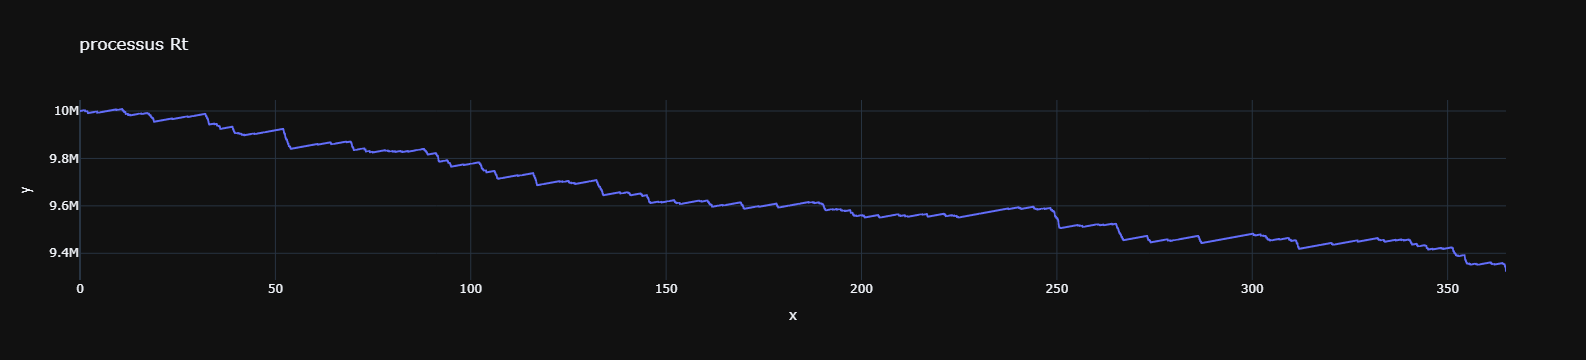

In [184]:
class Modele_A():
    def __init__(self, settings=ProjectSettings):
        """
        Initialisation du modele A.
        """
        self.settings = settings
        self.constructor = Constructuer_Chaine_Markovienne(states=(self.settings.parameters["lambda 01"],
                                                                   self.settings.parameters["lambda 02"],
                                                                   self.settings.parameters["lambda 03"]),
                                                           mu_zero_dis=get_a_random_distribution(3),
                                                           transitions=[get_a_random_distribution(3) for i in range(3)])
        self.theta = self.settings.parameters["N"]*max(self.settings.parameters["lambda 01"],self.settings.parameters["lambda 02"],self.settings.parameters["lambda 03"]) #contenant respectivement les temps d'occurence de nos sinistres et les montants
        self.global_array = np.array([0 for i in range(self.settings.parameters["limite machine de monte carlo limit"])])
        self.sinister = Sinistre(settings=self.settings, p=get_a_random_distribution(n=3))
        self.sub_models = [SubModel_A(settings=self.settings, constructor=self.constructor, sinister=self.sinister, theta=self.theta, global_array=self.global_array, global_number=i) for i in range(self.settings.parameters["N"])]
    def run(self):
        for i in range(self.settings.parameters["limite machine de monte carlo limit"]):
            self.sub_models[i].start()
        for i in range(self.settings.parameters["limite machine de monte carlo limit"]):
            self.sub_models[i].join()
        return np.sum(self.global_array)/self.settings.parameters["limite machine de monte carlo limit"]
test = Modele_A()
test.sub_models[0].run_ruine()

In [1]:
#test.run()

---
### Probabilité de ruine
---

---
### Modèle B
---

In [ ]:
class Modele_B():
    #Faire du modele B, une classe fille de la chaine de Markov n'est pas une idée interessante, car les assurés ne partagent pas de météo commune.
    #La parallélisation des calculs sera nécéssairement plus importante ici que pour le modele A
    def __init__(self, settings=Settings()):
        self.settings = settings
        pass

In [6]:
def tgraph_draw(states : list, state):
    """
    fonction qui nous permet d'afficher notre graph a 3 etats
    """
    try:
        display(Image.open("rsc_simu/state_0" + str(states.index(state)+ 1) +".png").resize((400,400), Image.Resampling.LANCZOS))
    except:
        display(Image.open("rsc_simu/place_holder.png").resize((400,400), Image.Resampling.LANCZOS))
    return ""

In [47]:
#bisect.insort(L, 3) 
"""
Insertion d'un élément x, dans une liste L supposée triée.
o(ln(n))
"""

"\nInsertion d'un élément x, dans une liste L supposée triée.\no(ln(n))\n"

# Bibliographie 
[1] https://makina-corpus.com/data-science/calculez-sur-gpu-avec-python-partie-1

In [ ]:
class SubModel_A(Chaine_Markovienne,threading.Thread):
    def __init__(self, settings, constructor, sinister, theta, global_array, global_numer):
        super().__init__(constructor=constructor)
        self.settings = settings
        random_mu_zero = [0]*3
        random_mu_zero[rd.randint(0,2)] = 1 #Car mu_zero est sensée etre déterministe
        self.sinister = sinister
        self.mu_zero = walkerTable(distribution=random_mu_zero,distribution_values=self.states)
        self.T, self.X, self.trajectory, self.theta = [], [], {0 : 0}, theta #contenant respectivement les temps d'occurence de nos sinistres et les montants
        self.global_array = global_array
        self.global_number = global_number
        pass
    def __repr__(self):
        return self.settings.__repr__() + "\n" + super().__repr__() #+ tgraph_draw(states=self.states, state=self.state)
    def __str__(self):
        return self.settings.__str__() + "\n" + super().__str__() #+ tgraph_draw(states=self.states, state=self.state)
    def run_pois(self, rounds=365, draw=True):
        N_sim = np.random.poisson(lam=self.theta*rounds)
        #Nous essayer d'optimiser le code de facon a que l'on ait besoin de simmuler toute la trajectoire de la chaine de markov, si et seulement si l'information qu'elle apport nous ait nécéssaire.
        for k in range(N_sim):
            va_transitoire = np.random.uniform(0,rounds)
            va_transitoire_aux = int(va_transitoire)
            if (va_transitoire_aux in self.trajectory): #recherche en temps constant
                if (np.random.uniform(0,self.theta) <= self.settings.parameters["N"]*self.trajectory[va_transitoire_aux]):
                    bisect.insort(self.T,va_transitoire) #o(lnn)
            else:
                for i in range(va_transitoire_aux - self.round + 2): #Nombre de tours qu'il nous reste pour que va_transitioire_aux soit dans le dictionnaire
                    self.state, self.round, self.trajectory[self.round] = self.transitions_walker_table[self.indexa[self.state]].run(), self.round + 1, self.state
                if (np.random.uniform(0,self.theta) <= self.settings.parameters["N"]*self.trajectory[va_transitoire_aux]):
                    bisect.insort(self.T,va_transitoire) #o(lnn)
        self.X = [self.sinister() for k in self.T]
        if draw:
            fig = px.ecdf(np.cumsum(np.array(self.X)), x=self.T, ecdfmode="standard", title="processus de poisson", ecdfnorm=None, template="plotly_dark")
            plt.step(self.T, np.cumsum(np.array(self.X)))
            fig.show()
    def run_ruine(self, rounds=365, draw=True):
        N_sim = np.random.poisson(lam=self.theta*rounds)
        #Nous essayer d'optimiser le code de facon a que l'on ait besoin de simmuler toute la trajectoire de la chaine de markov, si et seulement si l'information qu'elle apport nous ait nécéssaire.
        Rt = []
        for k in range(N_sim):
            va_transitoire = np.random.uniform(0,rounds)
            va_transitoire_aux = int(va_transitoire)
            if (va_transitoire_aux in self.trajectory): #recherche en temps constant
                if (np.random.uniform(0,self.theta) <= self.settings.parameters["N"]*self.trajectory[va_transitoire_aux]):
                    bisect.insort(self.T,va_transitoire) #o(lnn)
            else:
                for i in range(va_transitoire_aux - self.round + 2): #Nombre de tours qu'il nous reste pour que va_transitioire_aux soit dans le dictionnaire
                    self.state, self.round, self.trajectory[self.round] = self.transitions_walker_table[self.indexa[self.state]].run(), self.round + 1, self.state
                if (np.random.uniform(0,self.theta) <= self.settings.parameters["N"]*self.trajectory[va_transitoire_aux]):
                    bisect.insort(self.T,va_transitoire) #o(lnn)
        self.X = [self.sinister() for k in self.T]
        if drax:
            fig = px.ecdf(np.cumsum(np.array(self.X)), x=self.T, ecdfmode="standard", title="processus de poisson", ecdfnorm=None, template="plotly_dark")
            plt.step(self.T, np.cumsum(np.array(self.X)))
            fig.show()
    def run(self):
        #Surcouche de code, réécriture de la methode run
        #calcul de la ruine
        pass